Goal: Analyze how the number of buckets and number of batches influence the amount of padding used in the adaptive pooling pipeline

Author: David Gormley

Last Edited: 5/28/25


Structure

0) Import dependencies

1) Build Metadata

2) Padding Analysis

**0) Import Dependencies**

In [ ]:
# ─── Standard Library ───────────────────────────────────────────────────────
import os
import re
import glob
import time
import struct
import random
import shutil
from datetime import datetime
from collections import Counter, OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed

# ─── Data Handling ──────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Machine Learning & PyTorch ─────────────────────────────────────────────
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
import torch.backends.cudnn as cudnn

# ─── Computer Vision ────────────────────────────────────────────────────────
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
from PIL import Image, UnidentifiedImageError
import cv2
from skimage import io, color
import timm  # For accessing pretrained models beyond torchvision

# ─── Metrics & Evaluation ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

# ─── Progress Monitoring ────────────────────────────────────────────────────
from tqdm.auto import tqdm

# ─── Reproducibility ────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


**1) Build metadata**

In [ ]:
# ─── 1) CONFIG (Updated for Full Scan) ──────────────────────────────────
CONFIG = {
    'drive_image_folder': "/content/drive/MyDrive/'25 Spring/390/CMIL_SP2025_Patches_Apr27",  # read directly
    'label_csv': "/content/drive/MyDrive/'25 Spring/390/case_grade_match.csv",
    'meta_csv_full_scan': "/content/drive/MyDrive/'25 Spring/390/metadata_full_scan.csv",  # Distinct name for full metadata
    'batch_size': 32, # Example batch size
    'num_workers': 4, # Number of workers for metadata scanning and DataLoader
    'lr': 1e-3, # Example learning rate
    'num_epochs': 3, # Example epochs
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'), # Example device
    'resize_max': 512, # Example resize size for transforms (used in filtering/bucketing)
    'train_cases': [92,78,55,60,49,45,38,53,9,22,77,79,70],
    'test_cases': [34,1,99,62,89,2,12], #[34,1,99,62,89,2],
    'validation_cases':[90,21,3,85,25,98], #[12,90,21,3,85,25,98],
    'force_rebuild_metadata_full': True, # DO NOT change to False (unless you have not made any adjustments to cases, stain, or image size restrictions)
    'min_image_size': 50, # Used for filtering AFTER full scan
    'max_image_size': 100000, # Used for filtering AFTER full scan
    # --- Keep stains as a list for filtering later ---
    'target_stain': 'h&e' # Specify which stain to train/evaluate on for this run
}
# Combine all cases from train/val/test for the initial full metadata scan
all_cases_for_scan = set(CONFIG['train_cases'] + CONFIG['test_cases'] + CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(all_cases_for_scan)}")
print(f"Target stain for this run: {CONFIG['target_stain']}")

Cases included in initial full metadata scan: 26
Target stain for this run: h&e


In [ ]:
# ─── 1) HELPERS ──────────────────────────────────────────────────────────────
# Regex for filenames like "case_001_match_…png" or "case_12_unmatched_…png"
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root, max_retries=3, backoff=1.5):
    """
    Efficiently and safely scans a directory tree for .png files.
    Automatically retries failed directory reads (useful for Google Drive in Colab).

    Args:
        root (str): Root directory to scan.
        max_retries (int): Max retries per failed directory.
        backoff (float): Base multiplier for exponential delay between retries.
    """
    def scan_dir(path, retries=0):
        try:
            for entry in os.scandir(path):
                if entry.is_file() and entry.name.lower().endswith('.png'):
                    yield entry.path
                elif entry.is_dir():
                    yield from scan_dir(entry.path)
        except OSError as e:
            if retries < max_retries:
                wait = backoff ** retries
                print(f"⚠️  I/O error on {path} (attempt {retries+1}/{max_retries}). Retrying in {wait:.1f}s...")
                time.sleep(wait)
                yield from scan_dir(path, retries + 1)
            else:
                print(f"❌ Skipping {path} after {max_retries} failed attempts.")

    return scan_dir(root)

In [ ]:
# ─── 2) OPTIMIZED METADATA BUILDER ───────────────────────────────────────────
def build_metadata(image_folder, all_cases, meta_csv, stain,
                   force_rebuild=False, min_width=0, max_width=float('inf'),
                   num_workers=4):
    """
    Builds or loads a filtered metadata DataFrame:
      - only cases in `all_cases`
      - only files whose paths contain `stain`
      - only images with width/height in (min_width,max_width) or unknown dims (-1)
    """
    # Try loading existing CSV
    if os.path.exists(meta_csv) and not force_rebuild:
        try:
            df = pd.read_csv(meta_csv)
            required = {'path','case_number','stain','width','height'}
            if required.issubset(df.columns):
                # apply filters
                df = df[df.case_number.isin(all_cases)]
                df = df[((df.width  > min_width) & (df.width  < max_width)) | (df.width  == -1)]
                df = df[df.stain.str.lower() == stain.lower()]
                print(f"Loaded & filtered {len(df)} rows from {meta_csv}")
                return df
        except Exception:
            print(f"❗ Corrupt or missing `{meta_csv}`; rebuilding…")

    # Full rescan
    print(f"🔍 Scanning {image_folder} for stain='{stain}'…")
    files = list(fast_scan(image_folder))
    if not files:
        print(f"⚠️  No PNG files found in {image_folder}")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])

    def proc(p):
        m = case_pat.search(os.path.basename(p))
        if not m:
            return None
        cid = int(m.group(1))
        # case filter
        if cid not in all_cases:
            return None
        # stain filter
        if stain.lower() not in p.lower():
            return None
        # fast-header read
        w, h = -1, -1
        try:
            with open(p,'rb') as f:
                hdr = f.read(24)
            if hdr.startswith(b'\x89PNG\r\n\x1a\n') and hdr[12:16] == b'IHDR':
                w = struct.unpack('>I',hdr[16:20])[0]
                h = struct.unpack('>I',hdr[20:24])[0]
            else:
                with Image.open(p) as img:
                    w, h = img.size
        except Exception:
            pass
        # size filter
        if w != -1 and not (min_width < w < max_width):
            return None
        return {
            'path': p,
            'case_number': cid,
            'stain': stain.lower(),
            'width': w,
            'height': h
        }

    with ThreadPoolExecutor(max_workers=num_workers) as exe:
        rows = list(tqdm(exe.map(proc, files), total=len(files)))
    df = pd.DataFrame([r for r in rows if r])
    if df.empty:
        print(f"⚠️  No metadata built for stain='{stain}'")
        return df

    df.to_csv(meta_csv, index=False)
    print(f"✅ Built & saved {len(df)} rows to {meta_csv}")
    return df

In [ ]:
# create metadata
full_meta_df = build_metadata(
    image_folder=CONFIG['drive_image_folder'],
    all_cases=all_cases_for_scan,  # union of train + val + test
    meta_csv=CONFIG['meta_csv_full_scan'],
    stain=CONFIG['target_stain'],
    force_rebuild=CONFIG['force_rebuild_metadata_full'],
    min_width=CONFIG['min_image_size'],
    max_width=CONFIG['max_image_size'],
    num_workers=CONFIG['num_workers']
)

🔍 Scanning /content/drive/MyDrive/'25 Spring/390/CMIL_SP2025_Patches_Apr27 for stain='h&e'…


  0%|          | 0/64813 [00:00<?, ?it/s]

✅ Built & saved 5021 rows to /content/drive/MyDrive/'25 Spring/390/metadata_full_scan.csv


**2) Padding Analysis**

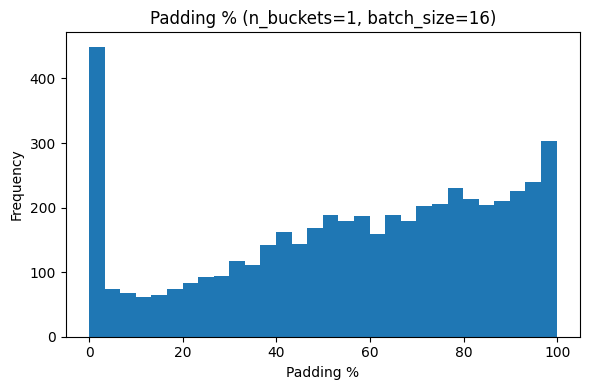

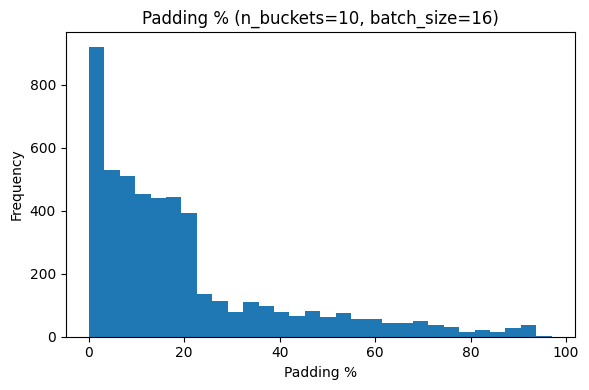

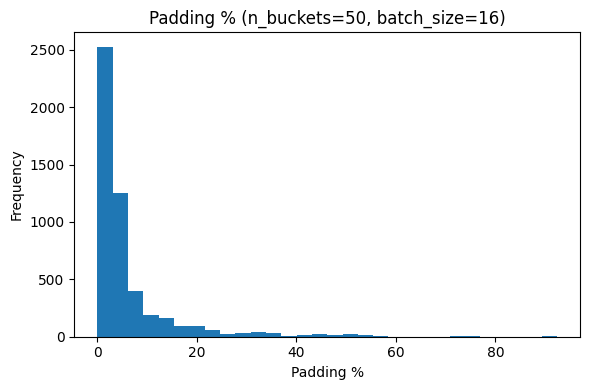

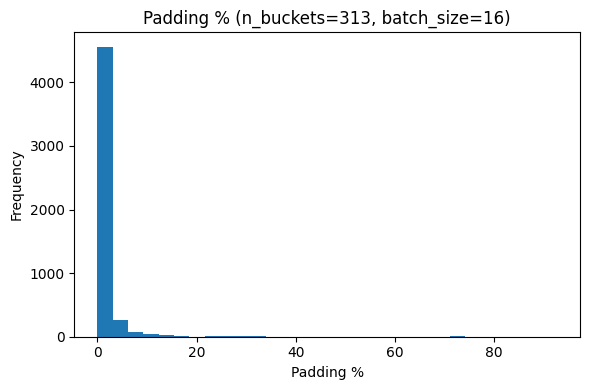

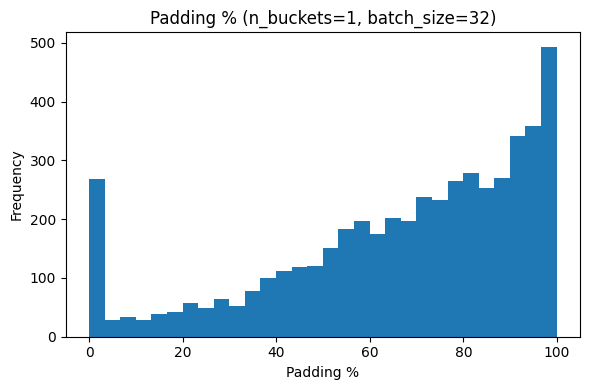

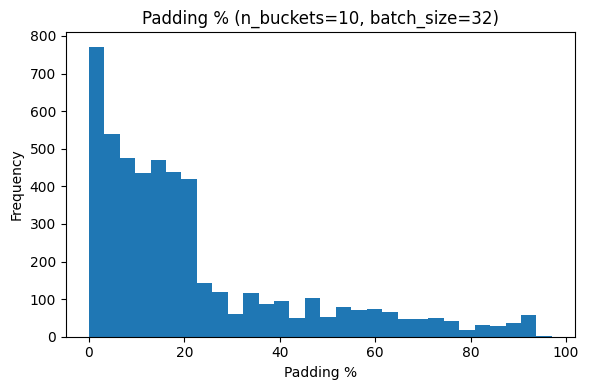

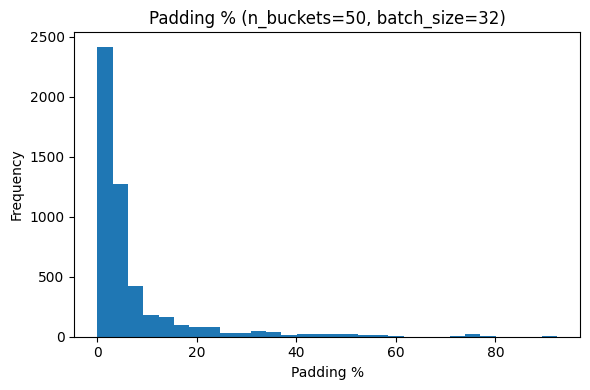

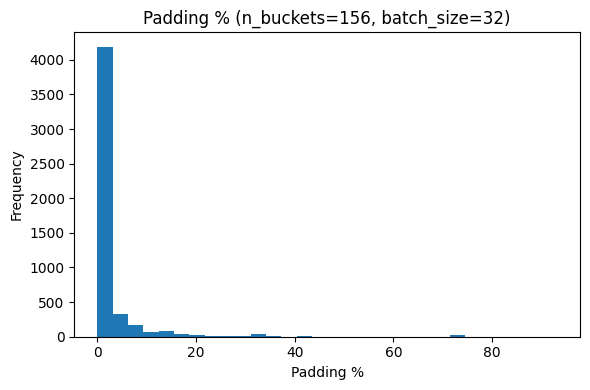

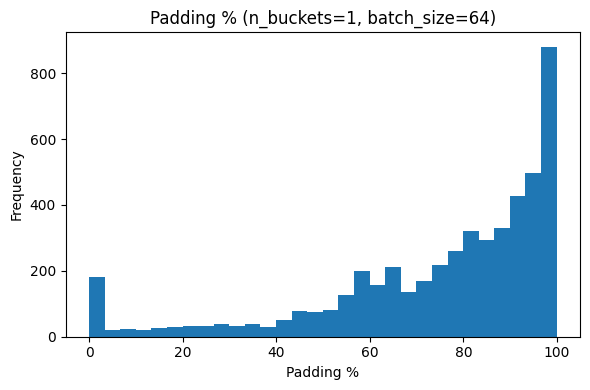

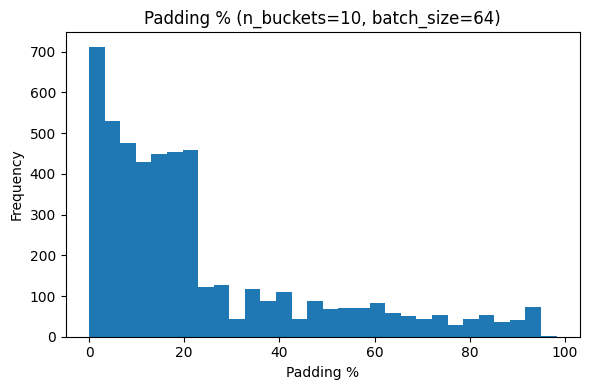

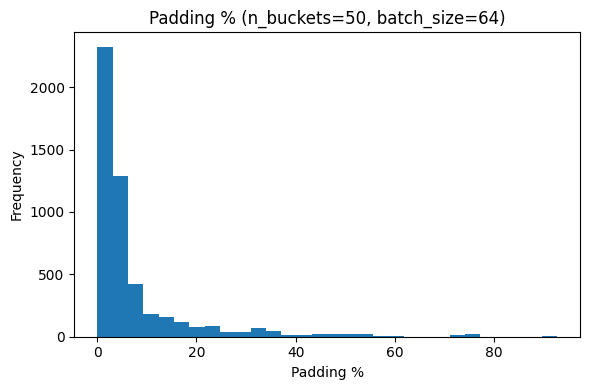

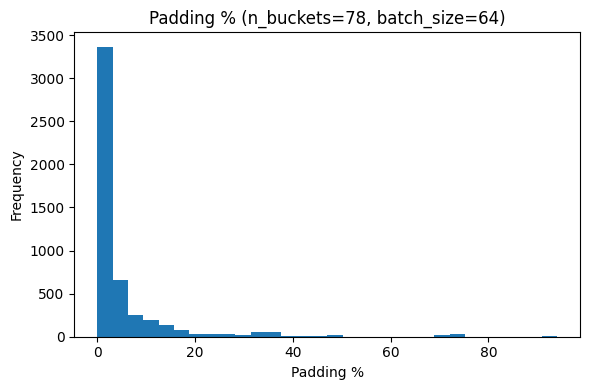

    n_buckets  batch_size     mean_%   median_%       q1_%       q3_%  \
0           1          16  56.603700  61.154514  35.574375  82.050463   
1          10          16  19.759552  13.700930   5.332359  24.085874   
2          50          16   5.945354   3.059103   0.520833   6.007538   
3         313          16   1.454200   0.454545   0.000000   0.914175   
4           1          32  66.506714  72.926097  51.478099  89.240405   
5          10          32  21.898662  15.147929   6.059172  27.968410   
6          50          32   6.605304   3.287117   0.581395   6.633222   
7         156          32   2.684186   0.595238   0.000000   1.470588   
8           1          64  74.694937  82.700893  62.921142  94.266082   
9          10          64  23.321671  15.703977   6.792059  31.574394   
10         50          64   7.085192   3.425884   0.641026   7.080316   
11         78          64   5.250007   0.961538   0.409836   4.719133   

    variance_%  
0   909.939213  
1   423.993532  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your metadata
csv_path = "/content/drive/MyDrive/'25 Spring/390/metadata_full_scan.csv"
full_meta_df = pd.read_csv(csv_path)

# 2) Helper: compute bucket boundaries
def make_boundaries_for_batches(sizes, n_buckets):
    if sizes is None or len(sizes) == 0 or n_buckets <= 1:
        return []
    sizes_series = pd.Series(sizes)
    quantiles = [(i / n_buckets) for i in range(1, n_buckets)]
    try:
        bounds = sizes_series.quantile(quantiles).tolist()
    except Exception:
        qs = [100 * i / n_buckets for i in range(1, n_buckets)]
        bounds = np.percentile(sizes, qs).tolist()
    # unique, sorted, integer thresholds
    return sorted(set(int(b) for b in bounds))

# 3) Sweep parameters
batch_sizes    = [16, 32, 64]
total_images   = len(full_meta_df)
widths  = full_meta_df['width'].values
heights = full_meta_df['height'].values

results = []

for batch_size in batch_sizes:
    dynamic_n = max(1, total_images // batch_size)
    n_buckets_list = [1, 10, 50, dynamic_n]

    for n_buckets in n_buckets_list:
        # 3a) Build buckets
        boundaries = make_boundaries_for_batches(widths, n_buckets)
        bucket_indices = {i: [] for i in range(len(boundaries) + 1)}
        for idx, w in enumerate(widths):
            bnum = sum(w > b for b in boundaries)
            bucket_indices[bnum].append(idx)

        # 3b) Compute padding % for every image
        padding_percs = []
        for indices in bucket_indices.values():
            for start in range(0, len(indices), batch_size):
                batch_inds = indices[start:start+batch_size]
                if not batch_inds:
                    continue
                H = heights[batch_inds].max()
                W = widths[batch_inds].max()
                for idx in batch_inds:
                    orig_area = heights[idx] * widths[idx]
                    pad_area  = (H * W) - orig_area
                    padding_percs.append(100 * pad_area / (H * W))

        arr = np.array(padding_percs)
        results.append({
            'n_buckets':     n_buckets,
            'batch_size':    batch_size,
            'mean_%':        arr.mean(),
            'median_%':      np.median(arr),
            'q1_%':          np.percentile(arr, 25),
            'q3_%':          np.percentile(arr, 75),
            'variance_%':    arr.var()
        })

        # 4) Plot histogram
        plt.figure(figsize=(6,4))
        plt.hist(padding_percs, bins=30)
        plt.title(f'Padding % (n_buckets={n_buckets}, batch_size={batch_size})')
        plt.xlabel('Padding %')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

# 5) Tabulate descriptive stats
stats_df = pd.DataFrame(results)
print(stats_df)


In [ ]:
stats_df

,n_buckets,batch_size,mean_%,median_%,q1_%,q3_%,variance_%
0,1,16,56.603700,61.154514,35.574375,82.050463,909.939213
1,10,16,19.759552,13.700930,5.332359,24.085874,423.993532
2,50,16,5.945354,3.059103,0.520833,6.007538,100.008579
3,313,16,1.454200,0.454545,0.000000,0.914175,29.173008
4,1,32,66.506714,72.926097,51.478099,89.240405,755.044351
5,10,32,21.898662,15.147929,6.059172,27.968410,490.637508
6,50,32,6.605304,3.287117,0.581395,6.633222,124.150940
7,156,32,2.684186,0.595238,0.000000,1.470588,60.453073
8,1,64,74.694937,82.700893,62.921142,94.266082,639.232260
9,10,64,23.321671,15.703977,6.792059,31.574394,548.225400
